In [1]:
from galvani import BioLogic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

In [2]:
def rrcrc_model(omega, R0, R1, C1, R2, C2):
    Z_R1C1 = R1 / (1 + 1j * omega * R1 * C1)
    Z_R2C2 = R2 / (1 + 1j * omega * R2 * C2)
    Z = R0 + Z_R1C1 + Z_R2C2
    return np.concatenate((np.real(Z), np.imag(Z)))

In [3]:
def rrcrc_cpe_model(omega, R0, R1, fs1, n1, R2, fs2, n2):
    Z_R1CPE1 = R1 / (1 + (1j * omega / fs1)**n1)
    Z_R2CPE2 = R2 / (1 + (1j * omega / fs2)**n2)
    Z = R0 + Z_R1CPE1 + Z_R2CPE2
    return np.concatenate((np.real(Z), np.imag(Z)))

# Import Data

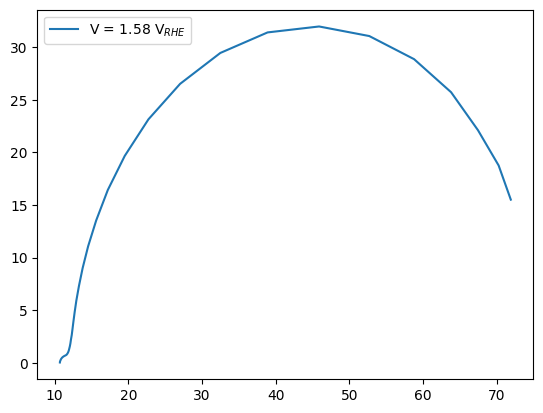

In [8]:
mpr_file = BioLogic.MPRfile('MPR files/1_58V_10cyc.mpr')
df = pd.DataFrame(mpr_file.data)

freq_min = 4
freq_max = 1e6
filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max)]

Ewe = filtered_df["<Ewe>/V"].mean()

frequencies = filtered_df['freq/Hz'].values
real = filtered_df['Re(Z)/Ohm'].values
imaginary = -filtered_df['-Im(Z)/Ohm'].values

Z = np.concatenate((real, imaginary))

omega = 2 * np.pi * frequencies

plt.plot(real, -imaginary, label = f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.legend()

# Simple R-RC-RC circuit

Optimal parameters: R0=10.934139856818208, R1=1.5357401148687668, C1=3.19517151839017e-05, R2=63.870719652984796, C2=0.00011908969502598487
R^2 (Real part): 0.999552768887952
R^2 (Imaginary part): 0.998428858933039


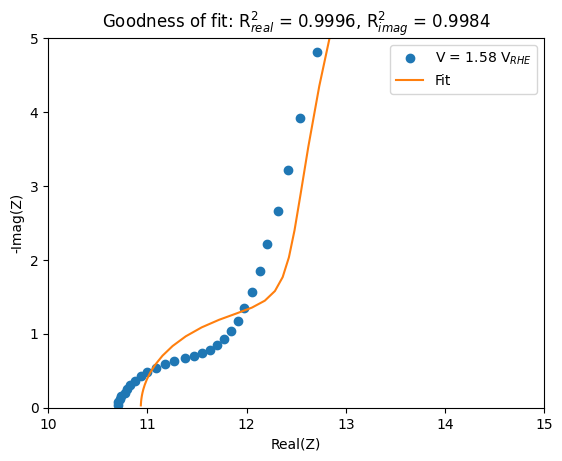

In [17]:
Rs_guess = 11.

R_guess = 1.5
n_guess = 1.
Q_guess = 3.2e-5

R2_guess = 6e4
n2_guess = 1.
Q2_guess = 1.2e-4

initial_guess = [Rs_guess, R_guess, Q_guess, R2_guess, Q2_guess]
bounds = (
    [5, 1, 1e-7, 1, 1e-7],  # Lower bounds
    [15, 5, 1e-3, 1e6, 1e-3]  # Upper bounds
)

popt, pcov = curve_fit(rrcrc_model, omega, Z, p0=initial_guess, bounds=bounds)

R0_opt, R1_opt, C1_opt, R2_opt, C2_opt = popt
print(f'Optimal parameters: R0={R0_opt}, R1={R1_opt}, C1={C1_opt}, R2={R2_opt}, C2={C2_opt}')

Z_fit = rrcrc_model(omega, *popt)
real_fit = Z_fit[:len(frequencies)]
imaginary_fit = Z_fit[len(frequencies):]

def calculate_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

r_squared_real = calculate_r_squared(real, real_fit)
r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)
print(f'R^2 (Real part): {r_squared_real}')
print(f'R^2 (Imaginary part): {r_squared_imaginary}')

plt.plot(real, -imaginary, 'o', label=f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.plot(real_fit, -imaginary_fit, '-', label='Fit')
plt.xlabel('Real(Z)')
plt.ylabel('-Imag(Z)')
plt.xlim([10,15])
plt.ylim([0,5])
plt.title(f'Goodness of fit: R$^2_{{real}}$ = {r_squared_real:.4f}, R$^2_{{imag}}$ = {r_squared_imaginary:.4f}')
plt.legend()


# Randle R-RC-RC circuit (CPE - constant phase element)

Optimal parameters: R0=10.660161203710535, R1=1.3671912075512223, fs1=57116.47428999789, n1=0.7964917766896544, R2=65.82133738935292, fs2=128.90727312742516, n2=0.9694577432272125
R^2 (Real part): 0.9998103257530602
R^2 (Imaginary part): 0.9994527534581721


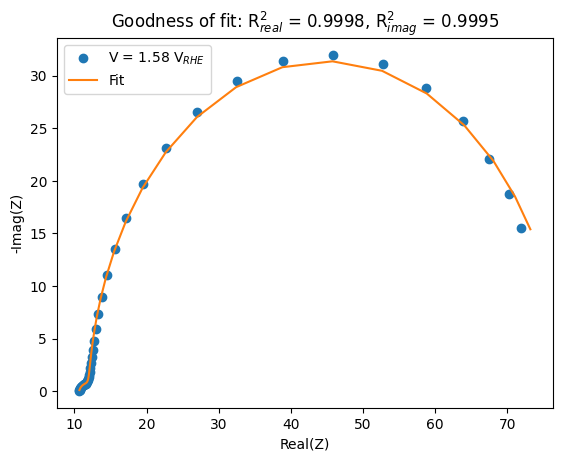

In [9]:
Rs_guess = 11.

R_guess = 1.5
n_guess = 1.
fs_guess = 10**1.3

R2_guess = 6e4
n2_guess = 1.
fs2_guess = 10**0.5

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

bounds = (
    [5, 1, 1e-2, 0.5, 1, 1e-2, 0.5],  # Lower bounds
    [15, 5, 1e7, 1.5, 1e6, 1e7, 1.5]  # Upper bounds

)

popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt
print(f'Optimal parameters: R0={R0_opt}, R1={R1_opt}, fs1={fs1_opt}, n1={n1_opt}, R2={R2_opt}, fs2={fs2_opt}, n2={n2_opt}')

Z_fit = rrcrc_cpe_model(omega, *popt)
real_fit = Z_fit[:len(frequencies)]
imaginary_fit = Z_fit[len(frequencies):]

def calculate_r_squared(observed, predicted):
    ss_res = np.sum((observed - predicted) ** 2)
    ss_tot = np.sum((observed - np.mean(observed)) ** 2)
    return 1 - (ss_res / ss_tot)

r_squared_real = calculate_r_squared(real, real_fit)
r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)
print(f'R^2 (Real part): {r_squared_real}')
print(f'R^2 (Imaginary part): {r_squared_imaginary}')

plt.plot(real, -imaginary, 'o', label=f"V = {Ewe:.2f} V$_{{RHE}}$")
plt.plot(real_fit, -imaginary_fit, '-', label='Fit')
plt.xlabel('Real(Z)')
plt.ylabel('-Imag(Z)')
#plt.xlim([10,15])
#plt.ylim([0,5])
plt.title(f'Goodness of fit: R$^2_{{real}}$ = {r_squared_real:.4f}, R$^2_{{imag}}$ = {r_squared_imaginary:.4f}')
plt.legend()


# Batch fitting 10 cycles with R-RCPE-RCPE circuit

## Find all files

In [5]:
import os

def find_files(root_folder, extension):
    file_list = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(extension):
                file_list.append(os.path.join(root, file))
    return file_list

# Example usage:
root_folder = "10 cycles imped"
extension = ".mpr"
mpr_files = find_files(root_folder, extension)
mpr_files.sort(reverse=True)

## Fit high frequency section

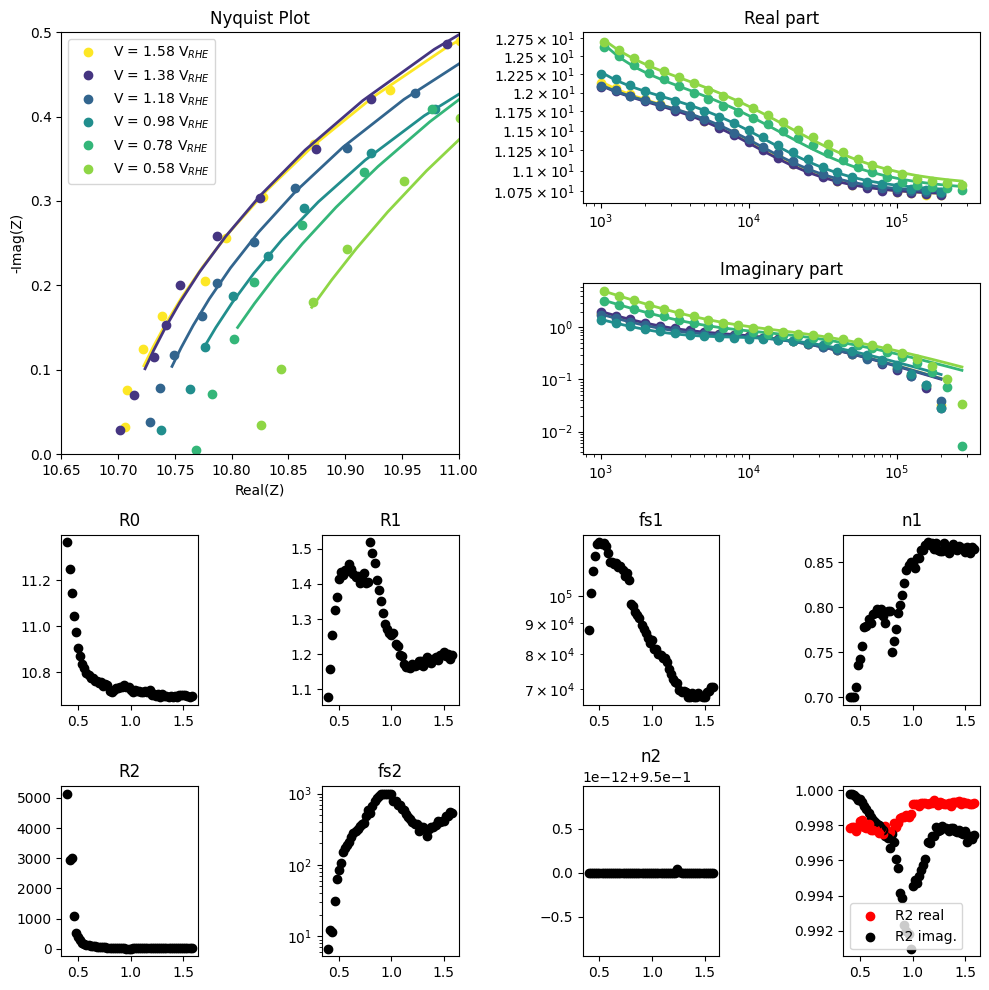

In [43]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

Rs_guess = 10.66

R_guess = 1.37
n_guess = 0.8
fs_guess = 5.7e4

R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

bounds = (
    [9., 1., 10**1, 0.7, 1, 10**0.1, 0.95],  # Lower bounds
    [12., 4., 10**7, 1.25, 1e8, 10**3, 1.05]  # Upper bounds

)

popt = []

fitted_values_HF = dict()


for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 1e3#4
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        fitted_values_HF[file_path] = popt
        #print(f'Ewe={Ewe:.2f} V, Optimal parameters: R0={R0_opt}, R1={R1_opt}, fs1={fs1_opt}, n1={n1_opt}, R2={R2_opt}, fs2={fs2_opt}, n2={n2_opt}')

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")

        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
ax1.set_xlim([10.65,11])
ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

## Fit whole range with HF values for first element

1.5805103 [1.06939167e+01 1.19742553e+00 7.04551097e+04 8.64737040e-01
 1.88491470e+01 5.28217764e+02 9.50000000e-01]
1.5805103 [1.06877018e+01 1.31716808e+00 5.69205425e+04 8.22735134e-01
 6.58574080e+01 1.28924520e+02 9.69069271e-01]
1.5605386 [1.06903827e+01 1.18570260e+00 7.06310077e+04 8.67249361e-01
 1.80152824e+01 5.42680204e+02 9.50000000e-01]


ValueError: `x0` is infeasible.

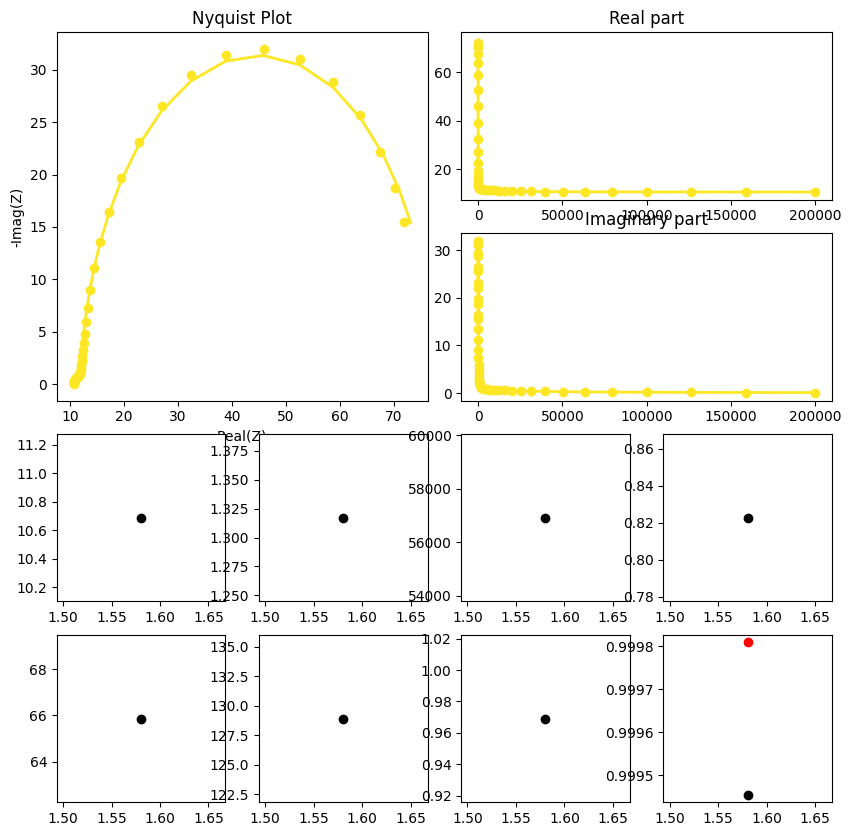

In [51]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('Nyquist Plot')

ax2 = fig.add_subplot(gs[0, 2:])
ax2.set_title('Real part')

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_title('Imaginary part')

axes = []
for i in range(4):
    for j in range(2, 4):
        ax = fig.add_subplot(gs[j, i])
        axes.append(ax)

from matplotlib.cm import viridis
colors = viridis(np.linspace(0, 1, len(mpr_files)))

# These values from the HR fit
Rs_guess = 10.69

R_guess = 1.197
n_guess = 0.865
fs_guess = 7.045e4

# These values from first fit from Ben
R2_guess = 65.8
n2_guess = 0.97
fs2_guess = 128.9

initial_guess = [Rs_guess, R_guess, fs_guess, n_guess, R2_guess, fs2_guess, n2_guess]

popt = []

for (n_file,file_path) in enumerate(mpr_files):
    mpr_file = BioLogic.MPRfile(file_path)
    df = pd.DataFrame(mpr_file.data)

    freq_min = 4
    freq_max = 1e6
    filtered_df = df[(df['freq/Hz'] >= freq_min) & (df['freq/Hz'] <= freq_max) & (df['-Im(Z)/Ohm'] > 0)]

    Ewe = filtered_df["<Ewe>/V"].mean()

    frequencies = filtered_df['freq/Hz'].values
    real = filtered_df['Re(Z)/Ohm'].values
    imaginary = -filtered_df['-Im(Z)/Ohm'].values

    Z = np.concatenate((real, imaginary))
    omega = 2 * np.pi * frequencies

    popt_HF = fitted_values_HF[file_path]

    ##################################### there is some problem here ###################################################
    bounds = (
    [0.95*popt_HF[0], 0.9*popt_HF[1], 0.5*popt_HF[2], 0.75*popt_HF[3], 1, 10**0.1, 0.95],  # Lower bounds
    [1.05*popt_HF[0], 1.1*popt_HF[1], 1.5*popt_HF[2], 1.25*popt_HF[3], 1e8, 10**3, 1.05]  # Upper bounds
    )
    #######################################################################################

    print (Ewe,popt_HF)
    try:
        if len(popt)>0:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=popt, bounds=bounds)
        else:
            popt, pcov = curve_fit(rrcrc_cpe_model, omega, Z, p0=initial_guess, bounds=bounds)

        R0_opt, R1_opt, fs1_opt, n1_opt, R2_opt, fs2_opt, n2_opt = popt

        
        print (Ewe,popt)
        

        Z_fit = rrcrc_cpe_model(omega, *popt)
        real_fit = Z_fit[:len(frequencies)]
        imaginary_fit = Z_fit[len(frequencies):]

        if n_file%10 == 0:
            ax1.plot(real, -imaginary, 'o', color=colors[n_file-1], label=f"V = {Ewe:.2f} V$_{{RHE}}$")
            ax1.plot(real_fit, -imaginary_fit, '-', lw = 2,  color=colors[n_file-1])
            ax1.set_xlabel('Real(Z)')
            ax1.set_ylabel('-Imag(Z)')

            ax2.plot(frequencies, real, 'o', color=colors[n_file-1])
            ax2.plot(frequencies, real_fit, '-', lw=2, color=colors[n_file-1])
            
            ax3.plot(frequencies, -imaginary, 'o',color=colors[n_file-1])
            ax3.plot(frequencies, -imaginary_fit, '-', lw=2, color=colors[n_file-1])

        axes[0].scatter(Ewe, R0_opt, c = "k")
        axes[2].scatter(Ewe, R1_opt, c = "k")
        axes[4].scatter(Ewe, fs1_opt, c = "k")
        axes[6].scatter(Ewe, n1_opt, c = "k")
        axes[1].scatter(Ewe, R2_opt, c = "k")
        axes[3].scatter(Ewe, fs2_opt, c = "k")
        axes[5].scatter(Ewe, n2_opt, c = "k")

        def calculate_r_squared(observed, predicted):
            ss_res = np.sum((observed - predicted) ** 2)
            ss_tot = np.sum((observed - np.mean(observed)) ** 2)
            return 1 - (ss_res / ss_tot)

        r_squared_real = calculate_r_squared(real, real_fit)
        r_squared_imaginary = calculate_r_squared(imaginary, imaginary_fit)

        if n_file == 0:
            axes[7].scatter(Ewe, r_squared_real, c = "r", label = "R2 real")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k", label = "R2 imag.")
        else:
            axes[7].scatter(Ewe, r_squared_real, c = "r")
            axes[7].scatter(Ewe, r_squared_imaginary, c = "k")

    except RuntimeError:
        print(f"Ewe={Ewe:.2f} V - No fit")

axes[0].set_title("R0")
axes[2].set_title("R1")
axes[4].set_title("fs1")
axes[4].set_yscale("log")
axes[6].set_title("n1")
axes[1].set_title("R2")
axes[3].set_title("fs2")
axes[3].set_yscale("log")
axes[5].set_title("n2")

axes[7].legend()
ax1.legend()
#ax1.set_xlim([10.65,11])
#ax1.set_ylim([0,0.5])

ax2.set_xscale("log")
ax2.set_yscale("log")
ax3.set_xscale("log")
ax3.set_yscale("log")

plt.tight_layout()

In [25]:
fitted_values_HF

{'10 cycles imped/1.2 to 1.58/1.2 to 1_20_PEIS_C01.mpr': array([1.06939167e+01, 1.19742553e+00, 7.04551097e+04, 8.64737040e-01,
        1.88491470e+01, 5.28217764e+02, 9.50000000e-01]),
 '10 cycles imped/1.2 to 1.58/1.2 to 1_19_PEIS_C01.mpr': array([1.06903827e+01, 1.18570260e+00, 7.06310077e+04, 8.67249361e-01,
        1.80152824e+01, 5.42680204e+02, 9.50000000e-01]),
 '10 cycles imped/1.2 to 1.58/1.2 to 1_18_PEIS_C01.mpr': array([1.06951714e+01, 1.20155737e+00, 6.95811576e+04, 8.60636477e-01,
        1.96238291e+01, 4.91115260e+02, 9.50000000e-01]),
 '10 cycles imped/1.2 to 1.58/1.2 to 1_17_PEIS_C01.mpr': array([1.07004016e+01, 1.19375480e+00, 6.92016618e+04, 8.66607515e-01,
        2.05593213e+01, 4.78754312e+02, 9.50000000e-01]),
 '10 cycles imped/1.2 to 1.58/1.2 to 1_16_PEIS_C01.mpr': array([1.07016764e+01, 1.20491135e+00, 6.79614725e+04, 8.61826577e-01,
        2.45562822e+01, 4.08089842e+02, 9.50000000e-01]),
 '10 cycles imped/1.2 to 1.58/1.2 to 1_15_PEIS_C01.mpr': array([1.0698

# Raw functions